# HVM Small-Amplitude Oscillatory Shear (SAOS)

**Hybrid Vitrimer Model — Two Maxwell modes + permanent plateau**

## Introduction

**Vitrimers** are a class of covalent adaptable networks (CANs) introduced by
Montarnal et al. (2011) that undergo **associative bond exchange reactions (BER)**:
covalent bonds rearrange their connectivity without ever breaking the network.
Unlike dissociative networks (where bonds break and reform), vitrimer topology
changes proceed through a concerted mechanism — one bond forms as another releases —
keeping the crosslink density constant at all times.

This associative exchange gives vitrimers a unique combination of properties:
- **Thermoset-like** mechanical integrity at low temperatures (BER frozen)
- **Thermoplastic-like** processability at high temperatures (BER active)
- **Self-healing** and **recyclability** through topology rearrangement
- A well-defined **topology freezing transition** temperature $T_v$

The **Hybrid Vitrimer Model (HVM)** captures these phenomena through a
three-subnetwork architecture built on the VLB transient network framework
(Vernerey, Long & Brighenti, 2017):

| Subnetwork | Physics | Stress contribution |
|:---|:---|:---|
| **Permanent (P)** | Covalent crosslinks (neo-Hookean) | $\sigma_P = G_P \gamma$ |
| **Exchangeable (E)** | Vitrimer BER bonds (evolving natural state) | $\sigma_E = G_E(\mu^E - \mu^E_{nat})$ |
| **Dissociative (D)** | Physical reversible bonds (Maxwell) | $\sigma_D = G_D(\mu^D - I)$ |

The **vitrimer hallmark** is the E-network: its natural-state tensor $\mu^E_{nat}$
evolves to track the current deformation via BER, so that $\sigma_E \to 0$ at
steady state — the network "remembers" the deformed configuration as its new
stress-free state. BER kinetics follow **Transition State Theory (TST)**:

$$k_{BER} = \nu_0 \exp\!\left(-\frac{E_a}{RT}\right) \cosh\!\left(\frac{V_{act} \cdot \sigma_{VM}^E}{RT}\right)$$

where mechanical stress **lowers the activation barrier**, accelerating exchange.

**Applicable materials:** Vitrimers (epoxy, polyester, polyurethane),
covalent adaptable networks, self-healing polymers, shape-memory polymers,
multi-mechanism networks.

> **Handbook:** For the complete mathematical formulation, ODE state vector,
> Clausius-Duhem thermodynamic derivation, and all protocol equations, see the
> [HVM Model Reference](../../docs/source/models/hvm/hvm.rst) in the Sphinx documentation.

## Learning Objectives

- Predict SAOS moduli for a 3-subnetwork vitrimer
- Identify $G_P$ from the low-frequency plateau
- Observe the factor-of-2: $\tau_{E,eff} = 1/(2 k_{BER,0})$
- Temperature sweep showing Arrhenius shift of crossover
- Compare limiting cases via factory methods

## Prerequisites

- Familiarity with linear viscoelasticity ($G'$, $G''$, loss tangent)
- Basic understanding of Maxwell model and superposition principle
- RheoJAX installation (`pip install rheojax`)

## Estimated Runtime

- ~30s (analytical, no ODE integration needed for SAOS)

## 1. Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import HVMLocal

jax, jnp = safe_import_jax()
verify_float64()
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

## 2. Theory

### SAOS Moduli

In the linear regime, the HVM SAOS moduli are a superposition of two Maxwell modes
(one from the E-network, one from the D-network) plus a permanent elastic plateau from
the P-network:

$$G'(\omega) = G_P + \frac{G_E \omega^2 \tau_{E,eff}^2}{1 + \omega^2 \tau_{E,eff}^2} + \frac{G_D \omega^2 \tau_D^2}{1 + \omega^2 \tau_D^2}$$

$$G''(\omega) = \frac{G_E \omega \tau_{E,eff}}{1 + \omega^2 \tau_{E,eff}^2} + \frac{G_D \omega \tau_D}{1 + \omega^2 \tau_D^2}$$

where $\tau_{E,eff} = 1/(2 k_{BER,0})$ (factor-of-2!) and $\tau_D = 1/k_d^D$.

**Key spectral features:**
- **Low-$\omega$:** $G'(\omega \to 0) = G_P$ — permanent network plateau reveals covalent crosslink density
- **High-$\omega$:** $G'(\omega \to \infty) = G_P + G_E + G_D$ — total network modulus
- **Two loss peaks** in $G''$: one at $\omega \sim 1/\tau_{E,eff}$ (vitrimer exchange), one at $\omega \sim 1/\tau_D$ (physical bonds)

### The Factor-of-2

The E-network relaxation time is $\tau_{E,eff} = 1/(2k_{BER,0})$, **not** $1/k_{BER,0}$.
This arises because both $\mu^E$ and $\mu^E_{nat}$ relax *toward each other* at rate
$k_{BER}$, so the stress difference $\Delta\mu = \mu^E - \mu^E_{nat}$ decays at
rate $2k_{BER}$. This is a fundamental vitrimer signature — see the
[HVM Handbook: Factor-of-2](../../docs/source/models/hvm/hvm.rst) for the full derivation.

### Parameter Overview

| Parameter | Symbol | Units | Typical Range | Physical Meaning |
|:---|:---:|:---:|:---:|:---|
| `G_P` | $G_P$ | Pa | $10^2$-$10^6$ | Permanent (covalent) crosslink modulus |
| `G_E` | $G_E$ | Pa | $10^2$-$10^6$ | Exchangeable (vitrimer) bond modulus |
| `G_D` | $G_D$ | Pa | $10^1$-$10^5$ | Dissociative (physical) bond modulus |
| `nu_0` | $\nu_0$ | 1/s | $10^8$-$10^{12}$ | TST attempt frequency |
| `E_a` | $E_a$ | J/mol | 40k-150k | Activation energy for BER |
| `V_act` | $V_{act}$ | m$^3$/mol | $10^{-7}$-$10^{-4}$ | Activation volume (mechanochemical coupling) |
| `T` | $T$ | K | 250-450 | Temperature |
| `k_d_D` | $k_d^D$ | 1/s | $10^{-3}$-$10^3$ | Dissociative bond detachment rate |

## 3. Model Setup

In [2]:
# Create full HVM model
model = HVMLocal()
model.parameters.set_value("G_P", 5000.0)
model.parameters.set_value("G_E", 3000.0)
model.parameters.set_value("G_D", 1000.0)
model.parameters.set_value("nu_0", 1e10)
model.parameters.set_value("E_a", 80e3)
model.parameters.set_value("V_act", 1e-5)
model.parameters.set_value("T", 350.0)
model.parameters.set_value("k_d_D", 10.0)

# Check effective relaxation times
tau_E = model.get_vitrimer_relaxation_time()
tau_D = 1.0 / model.k_d_D
k_BER_0 = model.compute_ber_rate_at_equilibrium()
regime = model.classify_vitrimer_regime()

print(f"k_BER_0 = {k_BER_0:.4f} 1/s")
print(f"τ_E_eff = 1/(2·k_BER_0) = {tau_E:.4f} s")
print(f"τ_D     = 1/k_d_D      = {tau_D:.4f} s")
print(f"Regime: {regime}")
print(f"Limiting case: {model.get_limiting_case()}")
print(f"Network fractions: {model.get_network_fractions()}")

k_BER_0 = 0.0115 1/s
τ_E_eff = 1/(2·k_BER_0) = 43.4593 s
τ_D     = 1/k_d_D      = 0.1000 s
Regime: rubbery
Limiting case: full HVM (G_P + G_E + G_D)
Network fractions: {'f_P': 0.5555555555555556, 'f_E': 0.3333333333333333, 'f_D': 0.1111111111111111}


## 4. SAOS Prediction

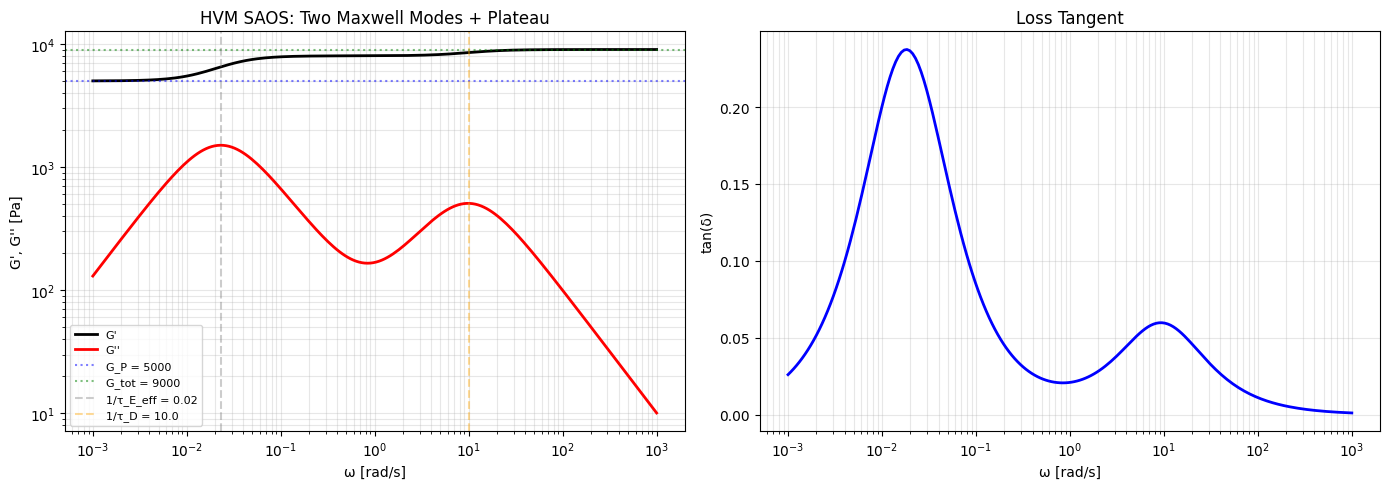

In [3]:
omega = np.logspace(-3, 3, 200)
G_prime, G_double_prime = model.predict_saos(omega)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# G', G'' vs omega
ax1.loglog(omega, G_prime, "k-", lw=2, label="G'")
ax1.loglog(omega, G_double_prime, "r-", lw=2, label="G''")
ax1.axhline(model.G_P, color="blue", ls=":", alpha=0.5, label=f"G_P = {model.G_P:.0f}")
ax1.axhline(model.G_P + model.G_E + model.G_D, color="green", ls=":", alpha=0.5,
            label=f"G_tot = {model.G_P + model.G_E + model.G_D:.0f}")
ax1.axvline(1/tau_E, color="gray", ls="--", alpha=0.4, label=f"1/τ_E_eff = {1/tau_E:.2f}")
ax1.axvline(1/tau_D, color="orange", ls="--", alpha=0.4, label=f"1/τ_D = {1/tau_D:.1f}")
ax1.set_xlabel("ω [rad/s]")
ax1.set_ylabel("G', G'' [Pa]")
ax1.set_title("HVM SAOS: Two Maxwell Modes + Plateau")
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3, which="both")

# tan(delta)
tan_delta = G_double_prime / G_prime
ax2.semilogx(omega, tan_delta, "b-", lw=2)
ax2.set_xlabel("ω [rad/s]")
ax2.set_ylabel("tan(δ)")
ax2.set_title("Loss Tangent")
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Factor-of-2 Demonstration

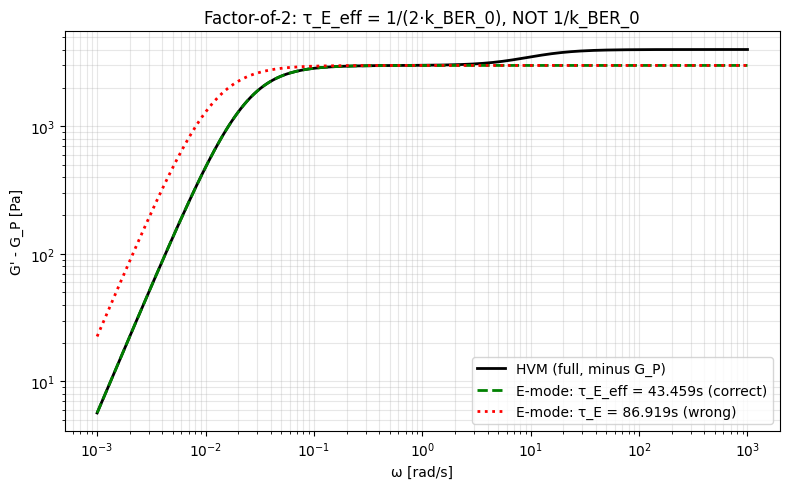

In [4]:
# Compare E-network contribution: Maxwell with τ_E = 1/k_BER_0 vs τ_E_eff = 1/(2·k_BER_0)
tau_E_naive = 1.0 / k_BER_0  # Without factor-of-2
tau_E_correct = tau_E          # With factor-of-2

G_E_prime_naive = model.G_E * (omega * tau_E_naive)**2 / (1 + (omega * tau_E_naive)**2)
G_E_prime_correct = model.G_E * (omega * tau_E_correct)**2 / (1 + (omega * tau_E_correct)**2)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(omega, G_prime - model.G_P, "k-", lw=2, label="HVM (full, minus G_P)")
ax.loglog(omega, G_E_prime_correct, "g--", lw=2, label=f"E-mode: τ_E_eff = {tau_E_correct:.3f}s (correct)")
ax.loglog(omega, G_E_prime_naive, "r:", lw=2, label=f"E-mode: τ_E = {tau_E_naive:.3f}s (wrong)")
ax.set_xlabel("ω [rad/s]")
ax.set_ylabel("G' - G_P [Pa]")
ax.set_title("Factor-of-2: τ_E_eff = 1/(2·k_BER_0), NOT 1/k_BER_0")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Temperature Sweep (Arrhenius)

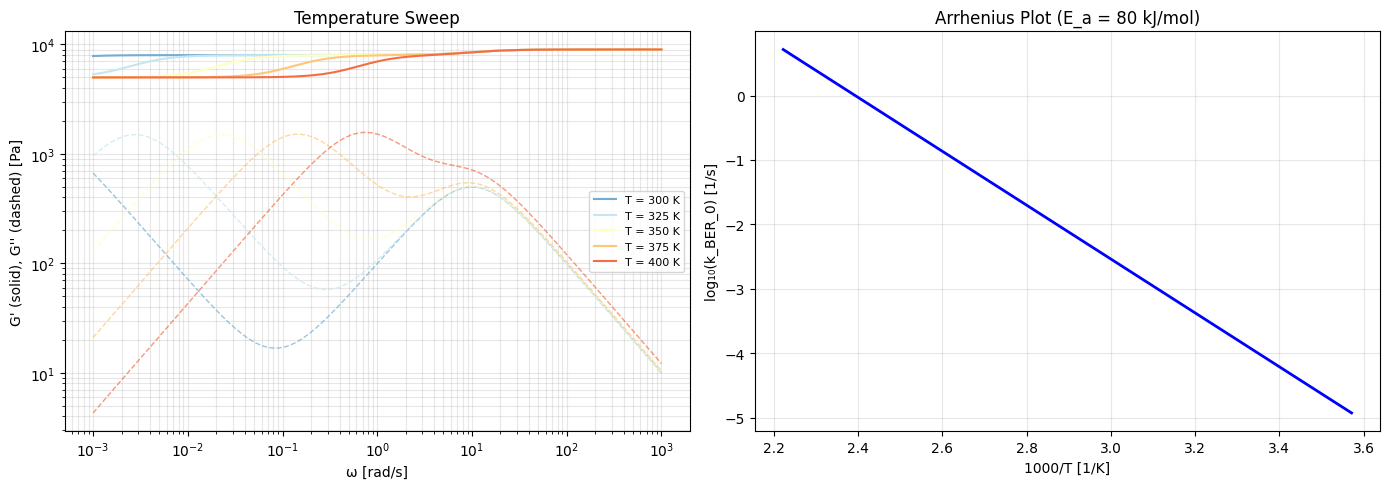

In [5]:
temperatures = [300, 325, 350, 375, 400]
colors = plt.cm.RdYlBu(np.linspace(0.8, 0.2, len(temperatures)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for T_val, color in zip(temperatures, colors):
    model.parameters.set_value("T", float(T_val))
    G_p, G_dp = model.predict_saos(omega)
    ax1.loglog(omega, G_p, "-", color=color, lw=1.5, label=f"T = {T_val} K")
    ax1.loglog(omega, G_dp, "--", color=color, lw=1, alpha=0.7)

ax1.set_xlabel("ω [rad/s]")
ax1.set_ylabel("G' (solid), G'' (dashed) [Pa]")
ax1.set_title("Temperature Sweep")
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3, which="both")

# Arrhenius plot
model.parameters.set_value("T", 350.0)  # Reset
T_range = np.linspace(280, 450, 100)
inv_T, log_k = model.arrhenius_plot_data(T_range)
ax2.plot(inv_T, log_k, "b-", lw=2)
ax2.set_xlabel("1000/T [1/K]")
ax2.set_ylabel("log₁₀(k_BER_0) [1/s]")
ax2.set_title(f"Arrhenius Plot (E_a = {model.E_a/1e3:.0f} kJ/mol)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Limiting Cases Comparison

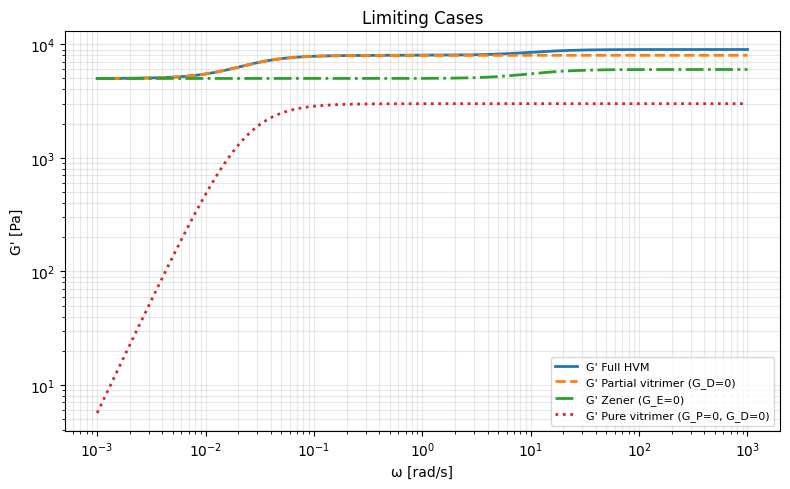

In [6]:
# Compare limiting cases
partial = HVMLocal.partial_vitrimer(G_P=5000, G_E=3000, nu_0=1e10, E_a=80e3, V_act=1e-5, T=350.0)
zener = HVMLocal.zener(G_P=5000, G_D=1000, k_d_D=10.0)
pure_vit = HVMLocal.pure_vitrimer(G_E=3000, nu_0=1e10, E_a=80e3, V_act=1e-5, T=350.0)

fig, ax = plt.subplots(figsize=(8, 5))
for m, label, ls in [
    (model, "Full HVM", "-"),
    (partial, "Partial vitrimer (G_D=0)", "--"),
    (zener, "Zener (G_E=0)", "-."),
    (pure_vit, "Pure vitrimer (G_P=0, G_D=0)", ":"),
]:
    G_p, G_dp = m.predict_saos(omega)
    ax.loglog(omega, G_p, ls, lw=2, label=f"G' {label}")

ax.set_xlabel("ω [rad/s]")
ax.set_ylabel("G' [Pa]")
ax.set_title("Limiting Cases")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## Key Takeaways

1. **$G'(\omega \to 0) = G_P$**: The permanent network provides a low-frequency plateau that reveals covalent crosslink density
2. **Factor-of-2**: $\tau_{E,eff} = 1/(2 k_{BER,0})$ because both $\mu^E$ and $\mu^E_{nat}$ relax toward each other — a fundamental vitrimer signature
3. **Arrhenius**: $k_{BER,0}(T) = \nu_0 \exp(-E_a/RT)$ shifts the crossover frequency with temperature
4. **Limiting cases**: Setting subnetwork moduli to zero recovers simpler models (neo-Hookean, Maxwell, Zener, pure vitrimer)

## Further Reading

**Handbook documentation:**
- [HVM Model Reference](../../docs/source/models/hvm/hvm.rst) — Complete constitutive equations and notation guide
- [HVM Protocol Derivations](../../docs/source/models/hvm/hvm_protocols.rst) — Step-by-step derivations for all 6 protocols
- [HVM Knowledge Extraction](../../docs/source/models/hvm/hvm_knowledge.rst) — Parameter-to-physics mapping and fitting strategy
- [HVM Advanced Theory](../../docs/source/models/hvm/hvm_advanced.rst) — Thermodynamic framework and numerical methods
- [VLB Foundation](../../docs/source/models/vlb/vlb.rst) — Underlying transient network theory

**Key references:**
1. Montarnal, D., Capelot, M., Tournilhac, F. & Leibler, L. (2011). "Silica-like malleable materials from permanent organic networks." *Science*, 334, 965-968.
2. Vernerey, F.J., Long, R. & Brighenti, R. (2017). "A statistically-based continuum theory for polymers with transient networks." *J. Mech. Phys. Solids*, 107, 1-20.
3. Meng, F., Saed, M.O. & Terentjev, E.M. (2019). "Elasticity and Relaxation in Full and Partial Vitrimer Networks." *Macromolecules*, 52(19), 7423-7429.

## Next Notebooks

- **Notebook 02**: Stress relaxation — bi-exponential decay + $G_P$ plateau
- **Notebook 03**: Startup shear — TST-driven stress overshoot
- **Notebook 04**: Creep compliance — vitrimer plastic flow
- **Notebook 05**: Flow curve — steady-state subnetwork decomposition
- **Notebook 06**: LAOS — nonlinear harmonic generation
- **Notebooks 08-13**: Full NLSQ + NUTS Bayesian inference pipeline